<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import torch 
import torch.nn.functional as F
from torch import nn
import scipy.io as io
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from torch.optim import SGD, Adam
from torch.utils import data
import sys 
import time
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)


cuda


In [2]:
M=16
Nt=2
Nr=2


Tx_NN=1024
Rx_NN=1024


In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(M+2*Nt*Nr, Tx_NN)
        self.fc2 = nn.Linear(Tx_NN, Tx_NN)
        self.fc3 = nn.Linear(Tx_NN, Tx_NN)
        self.fc4 = nn.Linear(Tx_NN, 2*Nt)
    def forward(self, x):
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = (self.fc4(x))
        y = x.reshape(-1,M,2*Nt)
        norm = 1 / torch.sqrt(2*torch.mean(y**2, dim=(1,2),keepdim=True))
        tx = y*norm
        tx = tx.reshape(-1,2*Nt)
        return tx
            
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1= nn.Linear(2*Nr+2*Nt*Nr, Rx_NN)
        self.fc2 = nn.Linear(Rx_NN, Rx_NN)
        self.fc3 = nn.Linear(Rx_NN, Rx_NN)
        self.fc4 = nn.Linear(Rx_NN, M)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        decoded = F.log_softmax(x, dim=-1)
        return decoded
    
def mimo_channel(xr, xi, Hr, Hi, sigma):
    """ xr,xi has shape  [B, Tx*N,1]
        Hr,Hi have shape [B, Rx, Tx]
        y = H*x + n
    """
    yr = torch.matmul(Hr,xr) - torch.matmul(Hi,xi)
    yi = torch.matmul(Hr,xi) + torch.matmul(Hi,xr)
    yr = yr + (torch.randn(yr.shape)*torch.tensor(sigma)).to(device)
    yi = yi + (torch.randn(yr.shape)*torch.tensor(sigma)).to(device)
    
    y = torch.cat([yr.reshape(-1,Nr), yi.reshape(-1,Nr)],-1)
    return y

In [4]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)


train_snr=12

Path = 'AE_Close_loop_SNR{}dB-1024NR'.format(train_snr)
checkpoint = torch.load(Path)
encoder.load_state_dict(checkpoint['Encoder'])
decoder.load_state_dict(checkpoint['Decoder'])

criterion= nn.NLLLoss()
opt = Adam(list(encoder.parameters())+list(decoder.parameters()), lr = 0.001)

In [5]:
# ##### Uncomment to train the AE from scratch

# start_time = time.time()
# print_interval = 1000
# loss_sv = np.array([])


# for snr in np.array([5,10,15,12]):
#     train_snr = snr
#     print("EsNo = {:.1f} dB".format(train_snr), flush=True) 
#     gradient_steps = int(5e2)
#     for epochs in range(gradient_steps):
#         num_ch= 640
        
#         Hr = (torch.randn([num_ch, Nr, Nt])/torch.tensor(np.sqrt(2))).to(device)
#         Hi = (torch.randn([num_ch, Nr, Nt])/torch.tensor(np.sqrt(2))).to(device)
#         Hr = Hr.repeat(1,M,1)
#         Hi = Hi.repeat(1,M,1)
#         HrR = Hr.reshape([-1, Nr,Nt])
#         HiR = Hi.reshape([-1 ,Nr,Nt])
        
#         H = torch.cat([HrR.reshape(-1, Nr*Nt),HiR.reshape(-1, Nr*Nt)], -1)
    

#         messages = (torch.arange(M)).repeat(num_ch).to(device)
        
#         one_hot = F.one_hot(messages).float()
#         transmitted = encoder(torch.cat([one_hot, H],-1))
    
#         txR = transmitted[:, np.arange(0,2)].reshape(-1, Nt,1)
#         txI = transmitted[:, np.arange(2,4)].reshape(-1, Nt,1)

#         sigma = np.sqrt(0.5/np.power(10, train_snr/10))
#         rx = mimo_channel(txR, txI, HrR, HiR, sigma)

#         y_pred = decoder(torch.cat([rx,H],-1))


#         cross_entropy = criterion(y_pred, messages) 


#         opt.zero_grad()

#         cross_entropy.backward()
#         opt.step()
#         l = cross_entropy.item()
#         if epochs%print_interval==0 or epochs==1:
# #             t.set_description("loss={:.5f}".format(l))
# #             t.refresh() # to show immediately the update
#             loss_sv = np.append(loss_sv,l)

# print(time.time()-start_time)

# plt.semilogy(loss_sv)
# plt.grid(True)





In [6]:
###### Save the trained model
# torch.save({
#             'Encoder': encoder.state_dict(),
#             'Decoder': decoder.state_dict(),
#             }, Path)


SNR=24.0: 100%|██████████| 25/25 [26:29<00:00, 63.60s/it] 


Text(0, 0.5, 'SER')

<Figure size 864x648 with 0 Axes>

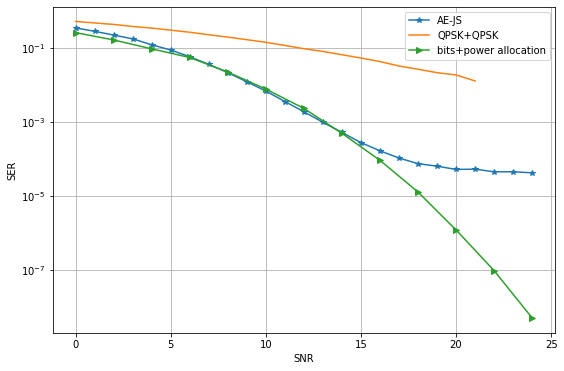

In [7]:
minErr = 1e4 # 50k = 8h
maxSym = minErr/1e-5
SNR_dB = np.arange(0, 25)
SER_arr = []

t = tqdm(range(len(SNR_dB)), desc="SNR=")
for II in t:
    t.set_description("SNR={:.1f}".format(SNR_dB[II]))
    totErr = 0 
    totSym = 0
    num_ch=128*5
    while totErr<minErr and (totSym<=maxSym):
        totSym += num_ch*M  
        num_ch= 128*5
        Hr = (torch.randn([num_ch, Nr, Nt])/torch.tensor(np.sqrt(2))).to(device)
        Hi = (torch.randn([num_ch, Nr, Nt])/torch.tensor(np.sqrt(2))).to(device)
    
        Hr = Hr.repeat(1,M,1)
        Hi = Hi.repeat(1,M,1)
        HrR = Hr.reshape([-1, Nr,Nt])
        HiR = Hi.reshape([-1 ,Nr,Nt])
        
        H = torch.cat([HrR.reshape(-1, Nr*Nt),HiR.reshape(-1, Nr*Nt)], -1)
    

        messages = (torch.arange(M)).repeat(num_ch).to(device)
        
        one_hot = F.one_hot(messages).float()
        transmitted = encoder(torch.cat([one_hot, H],-1))
    
        txR = transmitted[:, np.arange(0,2)].reshape(-1, Nt,1)
        txI = transmitted[:, np.arange(2,4)].reshape(-1, Nt,1)

        sigma = np.sqrt(0.5/np.power(10, SNR_dB[II]/10))
    
        rx = mimo_channel(txR, txI, HrR, HiR, sigma)
        y_pred = decoder(torch.cat([rx,H],-1))

        test_label = messages.to('cpu').detach().numpy()

        classification = torch.argmax(y_pred, axis=-1).to('cpu').detach().numpy()
        err = np.not_equal(classification , test_label)
        totErr += np.sum(err)
    SER_arr = np.append(SER_arr, totErr/(totSym))


    


plt.figure(figsize=(12,9))
SNR = np.arange(0, 22)

base_line = np.array([0.51663, 0.47059, 0.42939 ,0.3782,  0.34221, 0.30084 ,0.26423, 0.22573 ,0.1949,
0.16623, 0.14124, 0.1161 , 0.09486 ,0.07995, 0.06518 ,0.05308, 0.04256, 0.03233,
0.02639 ,0.02132, 0.0185 , 0.01276]) ### QPSK

baseline2 = np.array([ 0.2576662,0.1635421, 0.093646,0.05488565,0.02207,
0.0076935, 0.00230192,0.00048933, 0.000091090, 0.0000126550,
0.000001195 ,0.0000000950, 0.0000000050] ) ## bits power allocation



plt.figure(figsize=(9,6))    
plt.semilogy(SNR_dB, SER_arr,'-*', label='AE-JS')
plt.semilogy(SNR, base_line,label='QPSK+QPSK')
plt.semilogy(np.arange(0,25,2), baseline2,'->', label='bits+power allocation')
plt.grid(True)
plt.legend()
plt.xlabel('SNR')
plt.ylabel('SER')


In [8]:
# torch.save({
#             'Encoder': encoder.state_dict(),
#             'Decoder': decoder.state_dict(),
#             }, Path)



EV1=1.4: 100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


Text(0.5, 1.0, 'SNR=12dB, Ev2=0.5, train_Ev1=1.2 ')

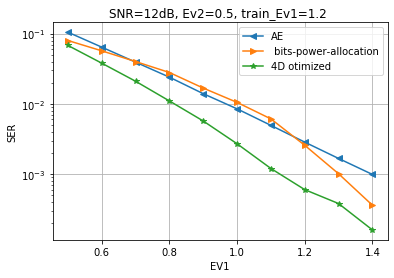

In [9]:
minErr = 1000 # 50k = 8h
maxSym = minErr/1e-5
EV1_arr = np.arange(0.5,1.5,0.1)
EV2 = 0.5

snr=12 ### SNR under consideration
num_ch = 2000
toterr=1e3
SER_arr = np.array([])

t = tqdm(range(len(EV1_arr)), desc="SNR=")
for III in t:
    t.set_description("EV1={:.1f}".format(EV1_arr[III]))
    t.refresh() # to show immediately the update   
    totErr = 0 
    totSym = 0
    totCorr = 0
    while totErr<toterr and totSym<=maxSym:
        totSym += num_ch * M
        
        Hr = (np.random.randn(num_ch, Nr, Nt)/np.sqrt(2))
        Hi = (np.random.randn(num_ch, Nr, Nt)/np.sqrt(2))
        
        for i in range(num_ch): 
            V = unitary_group.rvs(2)
            U = unitary_group.rvs(2)
            Htmp = (np.matmul(U,np.matmul(np.array([[EV1_arr[III],0],[0, EV2]]),np.conj(V).T)))
            Hr[i,:,:] = np.real(Htmp)
            Hi[i,:,:] = np.imag(Htmp)
        
        Hr = torch.from_numpy(Hr).float().to(device)
        Hi = torch.from_numpy(Hi).float().to(device)
        
        Hr = Hr.repeat(1,M,1)
        Hi = Hi.repeat(1,M,1)
        HrR = Hr.reshape([-1, Nr,Nt])
        HiR = Hi.reshape([-1 ,Nr,Nt]) 
        H = torch.cat([HrR.reshape(-1, Nr*Nt),HiR.reshape(-1, Nr*Nt)], -1) 
        
        
        
        messages = (torch.arange(M)).repeat(num_ch).to(device)
        
        one_hot = F.one_hot(messages).float()
        transmitted = encoder(torch.cat([one_hot, H],-1))
    
        txR = transmitted[:, np.arange(0,2)].reshape(-1, Nt,1)
        txI = transmitted[:, np.arange(2,4)].reshape(-1, Nt,1)


        sigma = np.sqrt(0.5/np.power(10, snr/10))
    
        rx = mimo_channel(txR, txI, HrR, HiR, sigma)

        y_pred = decoder(torch.cat([rx,H],-1))
        
    

        test_label = messages.to('cpu').detach().numpy()

        classification = torch.argmax(y_pred, axis=-1).to('cpu').detach().numpy()
        err = np.not_equal(classification , test_label)
        totErr += np.sum(err)
    SER_arr = np.append(SER_arr, totErr/(totSym))


plt.figure()
EV_baseline = np.arange(5, 15)/10

SER_ttt = np.array([0.08, 0.057,4.01e-2,2.8e-2, 1.679e-2, 1.05e-2,6.11e-3, 2.57e-3,1.01e-3,3.6e-4])
opt_SER = np.array([0.068, 0.038, 0.021, 0.011, 0.0057,0.0027,0.0012,0.0006,0.00038,0.00016])
plt.semilogy(EV1_arr, SER_arr, '-<',label='AE')
plt.semilogy(EV_baseline, SER_ttt, '->',label=' bits-power-allocation')
plt.semilogy(EV_baseline, opt_SER,'-*', label='4D otimized')
plt.grid()
plt.legend()
plt.xlabel('EV1')
plt.ylabel('SER')
plt.title('SNR=12dB, Ev2=0.5, train_Ev1=1.2 ')
